In [1]:
## import packages
from datetime import datetime
import os
import pandas as pd
import numpy as np
from itertools import chain
import hail as hl
import statsmodels.api as sm

Loading BokehJS ...

In [ ]:
DATASET = os.getenv('WORKSPACE_CDR')
bucket = os.getenv('WORKSPACE_BUCKET')

## Array PGS

In [3]:
# read matrix table 
mt_array = hl.read_matrix_table(f"{bucket}/ArrayData/Array_GT_QCed.mt")

Initializing Hail with default parameters...
/opt/conda/lib/python3.10/site-packages/hailtop/aiocloud/aiogoogle/user_config.py:43: UserWarning:

Reading spark-defaults.conf to determine GCS requester pays configuration. This is deprecated. Please use `hailctl config set gcs_requester_pays/project` and `hailctl config set gcs_requester_pays/buckets`.

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Running on Apache Spark version 3.3.0
SparkUI available at http://all-of-us-11150-m.us-central1-b.c.terra-vpc-sc-fd39b54c.internal:45861
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.130.post1-c69cd67afb8b
LOGGING: writing to /home/jupyter/workspaces/prswithwgsvsarraydata/hail-20241214-0449-0.2.130.post1-c69cd67afb8b.log


In [5]:
## read Sample_quant 
Sample_quant = hl.import_table(f"{bucket}/Pheno/quant_all.tsv", 
                         missing='',
                        impute=True,
                        types = {"person_id": "str"})
Sample_quant = Sample_quant.key_by("person_id")
mt_array_quant = mt_array.semi_join_cols(Sample_quant)
mt_array_quant = mt_array_quant.annotate_cols(**Sample_quant[mt_array_quant.s])


#### read Sample_binary
Sample_binary = hl.import_table(f"{bucket}/Pheno/binary_all.tsv", 
                         missing='',
                        impute=True,
                        types = {"person_id": "str"})
Sample_binary = Sample_binary.key_by("person_id")
mt_array_binary = mt_array.semi_join_cols(Sample_binary)
mt_array_binary = mt_array_binary.annotate_cols(**Sample_binary[mt_array_binary.s])

2024-12-14 04:49:49.990 Hail: INFO: Reading table to impute column types 1) / 1]
2024-12-14 04:49:54.707 Hail: INFO: Loading <StructExpression of type struct{person_id: str, Age: int32, is_sex_Male: int32, is_sex_Female: int32, is_White: int32, is_Black_or_African_American: int32, is_Native_Hawaiian_or_Other_Pacific_Islander: int32, is_Asian: int32, is_Middle_Eastern_or_North_African: int32, is_gender_Male: int32, is_gender_Female: int32, is_Hispanic: int32, is_anc_pred_eur: int32, is_anc_pred_amr: int32, is_anc_pred_afr: int32, is_anc_pred_sas: int32, is_anc_pred_eas: int32, is_anc_pred_mid: int32, PC1: float64, PC2: float64, PC3: float64, PC4: float64, PC5: float64, PC6: float64, PC7: float64, PC8: float64, PC9: float64, PC10: float64, PC11: float64, PC12: float64, PC13: float64, PC14: float64, PC15: float64, PC16: float64, BMI: float64, Height: float64, DBP: float64, SBP: float64, HbA1c: float64, leukocyte: float64, Lymphocyte: float64, RBC: float64, Neutrophil: float64, Hemoglobin_

In [6]:
db = hl.experimental.DB(region='us-central1', cloud='gcp')
mt_array_quant = db.annotate_rows_db(mt_array_quant, 'dbSNP_rsid') 

# Simplify the format of array<struct{rsid: str}> to a delimited string
mt_array_quant = mt_array_quant.annotate_rows(rsID=hl.delimit(mt_array_quant.dbSNP_rsid.map(lambda x: x.rsid), delimiter=","))
mt_array_quant = mt_array_quant.key_rows_by('rsID')

In [7]:
db = hl.experimental.DB(region='us-central1', cloud='gcp')
mt_array_binary = db.annotate_rows_db(mt_array_binary, 'dbSNP_rsid') 

# Simplify the format of array<struct{rsid: str}> to a delimited string
mt_array_binary = mt_array_binary.annotate_rows(rsID=hl.delimit(mt_array_binary.dbSNP_rsid.map(lambda x: x.rsid), delimiter=","))
mt_array_binary = mt_array_binary.key_rows_by('rsID')

In [8]:
# List of quant phenotypes
phenotypes = ["Height", "DBP", "HDL", "TC", "RBC", "leukocyte"]

# Loop through each phenotype and annotate it to the Matrix Table
for phenotype in phenotypes:
    print(f"Processing phenotype: {phenotype}")
    
    # Import the phenotype table
    phenotype_table = hl.import_table(
        f'{bucket}/PRScs/Array_{phenotype}_pst_eff_a1_b0.5_phiauto.txt',
        impute=True
    )
    
    # Key the phenotype table by 'rsID'
    phenotype_table = phenotype_table.key_by('rsID')
    
    # Annotate rows in the Matrix Table with the phenotype data
    mt_array_quant = mt_array_quant.annotate_rows(
        **{f"{phenotype}_PRScs_result": phenotype_table[mt_array_quant.rsID]}
    )

Processing phenotype: Height


2024-12-14 04:50:04.565 Hail: INFO: Reading table to impute column types
2024-12-14 04:50:06.059 Hail: INFO: Finished type imputation        (0 + 1) / 1]
  Loading field 'CHR' as type int32 (imputed)
  Loading field 'rsID' as type str (imputed)
  Loading field 'BP' as type int32 (imputed)
  Loading field 'A1_alt' as type str (imputed)
  Loading field 'A2_ref' as type str (imputed)
  Loading field 'BETA_posterior' as type float64 (imputed)


Processing phenotype: DBP


2024-12-14 04:50:07.067 Hail: INFO: Reading table to impute column types
2024-12-14 04:50:08.658 Hail: INFO: Finished type imputation        (0 + 1) / 1]
  Loading field 'CHR' as type int32 (imputed)
  Loading field 'rsID' as type str (imputed)
  Loading field 'BP' as type int32 (imputed)
  Loading field 'A1_alt' as type str (imputed)
  Loading field 'A2_ref' as type str (imputed)
  Loading field 'BETA_posterior' as type float64 (imputed)


Processing phenotype: HDL


2024-12-14 04:50:09.503 Hail: INFO: Reading table to impute column types
2024-12-14 04:50:10.991 Hail: INFO: Finished type imputation        (0 + 1) / 1]
  Loading field 'CHR' as type int32 (imputed)
  Loading field 'rsID' as type str (imputed)
  Loading field 'BP' as type int32 (imputed)
  Loading field 'A1_alt' as type str (imputed)
  Loading field 'A2_ref' as type str (imputed)
  Loading field 'BETA_posterior' as type float64 (imputed)


Processing phenotype: TC


2024-12-14 04:50:11.837 Hail: INFO: Reading table to impute column types
2024-12-14 04:50:13.239 Hail: INFO: Finished type imputation        (0 + 1) / 1]
  Loading field 'CHR' as type int32 (imputed)
  Loading field 'rsID' as type str (imputed)
  Loading field 'BP' as type int32 (imputed)
  Loading field 'A1_alt' as type str (imputed)
  Loading field 'A2_ref' as type str (imputed)
  Loading field 'BETA_posterior' as type float64 (imputed)


Processing phenotype: RBC


2024-12-14 04:50:14.090 Hail: INFO: Reading table to impute column types
2024-12-14 04:50:15.646 Hail: INFO: Finished type imputation        (0 + 1) / 1]
  Loading field 'CHR' as type int32 (imputed)
  Loading field 'rsID' as type str (imputed)
  Loading field 'BP' as type int32 (imputed)
  Loading field 'A1_alt' as type str (imputed)
  Loading field 'A2_ref' as type str (imputed)
  Loading field 'BETA_posterior' as type float64 (imputed)


Processing phenotype: leukocyte


2024-12-14 04:50:16.434 Hail: INFO: Reading table to impute column types
2024-12-14 04:50:17.847 Hail: INFO: Finished type imputation        (0 + 1) / 1]
  Loading field 'CHR' as type int32 (imputed)
  Loading field 'rsID' as type str (imputed)
  Loading field 'BP' as type int32 (imputed)
  Loading field 'A1_alt' as type str (imputed)
  Loading field 'A2_ref' as type str (imputed)
  Loading field 'BETA_posterior' as type float64 (imputed)


In [9]:
# List of binary phenotypes
phenotypes = ["T2D", "Asthma", "Breast_Cancer", "Colorectal_Cancer"]

# Loop through each phenotype and annotate it to the Matrix Table
for phenotype in phenotypes:
    print(f"Processing phenotype: {phenotype}")
    
    # Import the phenotype table
    phenotype_table = hl.import_table(
        f'{bucket}/PRScs/Array_{phenotype}_pst_eff_a1_b0.5_phiauto.txt',
        impute=True
    )
    
    # Key the phenotype table by 'rsID'
    phenotype_table = phenotype_table.key_by('rsID')
    
    # Annotate rows in the Matrix Table with the phenotype data
    mt_array_binary = mt_array_binary.annotate_rows(
        **{f"{phenotype}_PRScs_result": phenotype_table[mt_array_binary.rsID]}
    )

Processing phenotype: T2D


2024-12-14 04:50:18.758 Hail: INFO: Reading table to impute column types
2024-12-14 04:50:20.122 Hail: INFO: Finished type imputation        (0 + 1) / 1]
  Loading field 'CHR' as type int32 (imputed)
  Loading field 'rsID' as type str (imputed)
  Loading field 'BP' as type int32 (imputed)
  Loading field 'A1_alt' as type str (imputed)
  Loading field 'A2_ref' as type str (imputed)
  Loading field 'BETA_posterior' as type float64 (imputed)


Processing phenotype: Asthma


2024-12-14 04:50:20.967 Hail: INFO: Reading table to impute column types
2024-12-14 04:50:22.384 Hail: INFO: Finished type imputation        (0 + 1) / 1]
  Loading field 'CHR' as type int32 (imputed)
  Loading field 'rsID' as type str (imputed)
  Loading field 'BP' as type int32 (imputed)
  Loading field 'A1_alt' as type str (imputed)
  Loading field 'A2_ref' as type str (imputed)
  Loading field 'BETA_posterior' as type float64 (imputed)


Processing phenotype: Breast_Cancer


2024-12-14 04:50:23.148 Hail: INFO: Reading table to impute column types
2024-12-14 04:50:24.523 Hail: INFO: Finished type imputation        (0 + 1) / 1]
  Loading field 'CHR' as type int32 (imputed)
  Loading field 'rsID' as type str (imputed)
  Loading field 'BP' as type int32 (imputed)
  Loading field 'A1_alt' as type str (imputed)
  Loading field 'A2_ref' as type str (imputed)
  Loading field 'BETA_posterior' as type float64 (imputed)


Processing phenotype: Colorectal_Cancer


2024-12-14 04:50:25.437 Hail: INFO: Reading table to impute column types
2024-12-14 04:50:26.794 Hail: INFO: Finished type imputation        (0 + 1) / 1]
  Loading field 'CHR' as type int32 (imputed)
  Loading field 'rsID' as type str (imputed)
  Loading field 'BP' as type int32 (imputed)
  Loading field 'A1_alt' as type str (imputed)
  Loading field 'A2_ref' as type str (imputed)
  Loading field 'BETA_posterior' as type float64 (imputed)


In [9]:
# Compute PGS
phenotypes = ["Height", "DBP", "HDL", "TC", "RBC", "leukocyte"]

# Annotate PGS for all phenotypes
mt_array_quant = mt_array_quant.annotate_cols(**{
    f"{phenotype}_pgs": hl.struct(
        pgs=hl.agg.sum(
            mt_array_quant[f"{phenotype}_PRScs_result"]["BETA_posterior"] * mt_array_quant.GT
        )
    )
    for phenotype in phenotypes
})

In [10]:
# Compute PGS
phenotypes = ["T2D", "Asthma", "Breast_Cancer", "Colorectal_Cancer"]

# Annotate PGS for all phenotypes
mt_array_binary = mt_array_binary.annotate_cols(**{
    f"{phenotype}_pgs": hl.struct(
        pgs=hl.agg.sum(
            mt_array_binary[f"{phenotype}_PRScs_result"]["BETA_posterior"] * mt_array_binary.GT
        )
    )
    for phenotype in phenotypes
})

In [11]:
def export_Scores(mt, pheno, mt_type, method):
    export_filename = f"{bucket}/Scores/" + mt_type + "/" + pheno + "_" + method + ".bgz"
    sample_info = mt.cols().select(
        "Age", 'is_sex_Male', 'is_sex_Female', 
        "PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", 
        "PC9", "PC10", "PC11", "PC12", "PC13", "PC14", "PC15", "PC16", 
        pheno + "_pgs", pheno)
    sample_info = sample_info.annotate(**sample_info[pheno + "_pgs"])
    sample_info = sample_info.drop(pheno + "_pgs")
    sample_info.export(export_filename)

In [12]:
export_Scores(mt_array_quant, "DBP", "Array", "PRScs")
export_Scores(mt_array_quant, "HDL", "Array", "PRScs")
export_Scores(mt_array_quant, "Height", "Array", "PRScs")
export_Scores(mt_array_quant, "RBC", "Array", "PRScs")
export_Scores(mt_array_quant, "TC", "Array", "PRScs")
export_Scores(mt_array_quant, "leukocyte", "Array", "PRScs")

export_Scores(mt_array_binary, "T2D", "Array", "PRScs")
export_Scores(mt_array_binary, "Asthma", "Array", "PRScs")
export_Scores(mt_array_binary, "Breast_Cancer", "Array", "PRScs")
export_Scores(mt_array_binary, "Colorectal_Cancer", "Array", "PRScs")

2024-12-01 06:59:00.778 Hail: WARN: cols(): Resulting column table is sorted by 'col_key'.
    To preserve matrix table column order, first unkey columns with 'key_cols_by()'
2024-12-01 07:02:45.014 Hail: INFO: Ordering unsorted dataset with network shuffle
2024-12-01 07:02:46.329 Hail: INFO: Ordering unsorted dataset with network shuffle
2024-12-01 07:02:51.665 Hail: INFO: wrote table with 284574 rows in 1 partition to /tmp/__iruid_28421-48U7AYn0qStGBk9Qoae8ib
2024-12-01 07:09:18.127 Hail: INFO: Coerced sorted dataset       (48 + 16) / 64]
2024-12-01 07:09:19.743 Hail: INFO: merging 65 files totalling 6.7M... 40) / 64]
2024-12-01 07:09:20.233 Hail: INFO: while writing:
    gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/Array/DBP_PRScs.bgz
  merge time: 489.516ms
2024-12-01 07:12:29.521 Hail: INFO: Ordering unsorted dataset with network shuffle
2024-12-01 07:12:30.643 Hail: INFO: Ordering unsorted dataset with network shuffle
2024-12-01 07:12:33.774 Hail: INFO: wrote table 

In [13]:
%%bash

base_path="gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/Array"
phenotypes=("DBP" "HDL" "Height" "RBC" "TC" "leukocyte" "T2D" "Asthma" "Breast_Cancer" "Colorectal_Cancer")

for phenotype in "${phenotypes[@]}"; do
    gsutil mv "${base_path}/${phenotype}_PRScs.bgz" "${base_path}/${phenotype}_PRScs.gz"
done

Copying gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/Array/DBP_PRScs.bgz [Content-Type=application/octet-stream]...
Removing gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/Array/DBP_PRScs.bgz...

Operation completed over 1 objects/6.7 MiB.                                      
Copying gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/Array/HDL_PRScs.bgz [Content-Type=application/octet-stream]...
Removing gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/Array/HDL_PRScs.bgz...

Operation completed over 1 objects/6.6 MiB.                                      
Copying gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/Array/Height_PRScs.bgz [Content-Type=application/octet-stream]...
Removing gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/Array/Height_PRScs.bgz...

Operation completed over 1 objects/6.7 MiB.                                      
Copying gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/Array/RBC_PRScs

## WGS PGS

In [ ]:
mt_wgs_path = os.getenv("WGS_HAIL_STORAGE_PATH")
mt_wgs = hl.read_matrix_table(mt_wgs_path)

# read QC'ed variants
var_wgs = hl.read_table(f'{bucket}/WGSData/WGS_Vars_QCed.ht')

# subset the matrix table 
mt_wgs = mt_wgs.semi_join_rows(var_wgs)

# retrieve relavent fields
mt_wgs = mt_wgs.select_rows(rsid = mt_wgs.rsid)
mt_wgs = mt_wgs.select_entries(GT = mt_wgs.GT.n_alt_alleles())

Initializing Hail with default parameters...
/opt/conda/lib/python3.10/site-packages/hailtop/aiocloud/aiogoogle/user_config.py:43: UserWarning:

Reading spark-defaults.conf to determine GCS requester pays configuration. This is deprecated. Please use `hailctl config set gcs_requester_pays/project` and `hailctl config set gcs_requester_pays/buckets`.

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [5]:
mt_wgs.write(f"{bucket}/WGSData/WGS_GT_QCed.mt", overwrite = True)

2024-12-02 05:46:09.116 Hail: INFO: wrote matrix table with 8996707 rows and 98590 columns in 140126 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/WGSData/WGS_GT_QCed.mt


In [3]:
# read matrix table 
mt_wgs = hl.read_matrix_table(f"{bucket}/WGSData/WGS_GT_QCed.mt")

Initializing Hail with default parameters...
/opt/conda/lib/python3.10/site-packages/hailtop/aiocloud/aiogoogle/user_config.py:43: UserWarning:

Reading spark-defaults.conf to determine GCS requester pays configuration. This is deprecated. Please use `hailctl config set gcs_requester_pays/project` and `hailctl config set gcs_requester_pays/buckets`.

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Running on Apache Spark version 3.3.0
SparkUI available at http://all-of-us-11150-m.us-central1-b.c.terra-vpc-sc-fd39b54c.internal:39555
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.130.post1-c69cd67afb8b
LOGGING: writing to /home/jupyter/workspaces/prswithwgsvsarraydata/hail-20241202-1712-0.2.130.post1-c69cd67afb8b.log


In [4]:
## read Sample_quant 
Sample_quant = hl.import_table(f"{bucket}/Pheno/quant_all.tsv", 
                         missing='',
                        impute=True,
                        types = {"person_id": "str"})
Sample_quant = Sample_quant.key_by("person_id")
mt_wgs_quant = mt_wgs.semi_join_cols(Sample_quant)
mt_wgs_quant = mt_wgs_quant.annotate_cols(**Sample_quant[mt_wgs_quant.s])


#### read Sample_binary
Sample_binary = hl.import_table(f"{bucket}/Pheno/binary_all.tsv", 
                         missing='',
                        impute=True,
                        types = {"person_id": "str"})
Sample_binary = Sample_binary.key_by("person_id")
mt_wgs_binary = mt_wgs.semi_join_cols(Sample_binary)
mt_wgs_binary = mt_wgs_binary.annotate_cols(**Sample_binary[mt_wgs_binary.s])

2024-12-02 17:13:18.001 Hail: INFO: Reading table to impute column types 1) / 1]
2024-12-02 17:13:26.159 Hail: INFO: Loading <StructExpression of type struct{person_id: str, Age: int32, is_sex_Male: int32, is_sex_Female: int32, is_White: int32, is_Black_or_African_American: int32, is_Native_Hawaiian_or_Other_Pacific_Islander: int32, is_Asian: int32, is_Middle_Eastern_or_North_African: int32, is_gender_Male: int32, is_gender_Female: int32, is_Hispanic: int32, is_anc_pred_eur: int32, is_anc_pred_amr: int32, is_anc_pred_afr: int32, is_anc_pred_sas: int32, is_anc_pred_eas: int32, is_anc_pred_mid: int32, PC1: float64, PC2: float64, PC3: float64, PC4: float64, PC5: float64, PC6: float64, PC7: float64, PC8: float64, PC9: float64, PC10: float64, PC11: float64, PC12: float64, PC13: float64, PC14: float64, PC15: float64, PC16: float64, BMI: float64, Height: float64, DBP: float64, SBP: float64, HbA1c: float64, leukocyte: float64, Lymphocyte: float64, RBC: float64, Neutrophil: float64, Hemoglobin_

In [5]:
def process_matrix_table(mt, db, region='us-central1', cloud='gcp'):
    # Annotate rows with dbSNP_rsid
    mt = db.annotate_rows_db(mt, 'dbSNP_rsid')
    
    # Simplify the format of dbSNP_rsid to a delimited string
    mt = mt.annotate_rows(rsID=hl.delimit(mt.dbSNP_rsid.map(lambda x: x.rsid), delimiter=","))
    
    # Key rows by rsID
    mt = mt.key_rows_by('rsID')
    
    return mt

# Define the DB connection
db = hl.experimental.DB(region='us-central1', cloud='gcp')

# Process the mt_wgs_quant and mt_wgs_binary using the helper function
mt_wgs_quant = process_matrix_table(mt_wgs_quant, db)
mt_wgs_binary = process_matrix_table(mt_wgs_binary, db)

In [6]:
# Define the list of phenotypes for both quant and binary types
quant_phenotypes = ["Height", "DBP", "HDL", "TC", "RBC", "leukocyte"]
binary_phenotypes = ["T2D", "Asthma", "Breast_Cancer", "Colorectal_Cancer"]

# Function to annotate phenotypes to the MatrixTable
def annotate_phenotypes(phenotypes, mt, bucket, phenotype_type="quant"):
    for phenotype in phenotypes:
        print(f"Processing phenotype: {phenotype}")
        
        # Import the phenotype table
        phenotype_table = hl.import_table(
            f'{bucket}/PRScs/WGS_{phenotype}_pst_eff_a1_b0.5_phiauto.txt',
            impute=True
        )
        
        # Key the phenotype table by 'rsID'
        phenotype_table = phenotype_table.key_by('rsID')
        
        # Annotate rows in the Matrix Table with the phenotype data
        if phenotype_type == "quant":
            mt = mt.annotate_rows(
                **{f"{phenotype}_PRScs_result": phenotype_table[mt.rsID]}
            )
        elif phenotype_type == "binary":
            mt = mt.annotate_rows(
                **{f"{phenotype}_PRScs_result": phenotype_table[mt.rsID]}
            )
        
    return mt

# Annotate quant phenotypes to the mt_wgs_quant
mt_wgs_quant = annotate_phenotypes(quant_phenotypes, mt_wgs_quant, bucket, phenotype_type="quant")

# Annotate binary phenotypes to the mt_wgs_binary
mt_wgs_binary = annotate_phenotypes(binary_phenotypes, mt_wgs_binary, bucket, phenotype_type="binary")

Processing phenotype: Height


2024-12-02 17:13:35.174 Hail: INFO: Reading table to impute column types
2024-12-02 17:13:38.254 Hail: INFO: Finished type imputation        (0 + 1) / 1]
  Loading field 'CHR' as type int32 (imputed)
  Loading field 'rsID' as type str (imputed)
  Loading field 'BP' as type int32 (imputed)
  Loading field 'A1_alt' as type str (imputed)
  Loading field 'A2_ref' as type str (imputed)
  Loading field 'BETA_posterior' as type float64 (imputed)


Processing phenotype: DBP


2024-12-02 17:13:39.094 Hail: INFO: Reading table to impute column types
2024-12-02 17:13:41.958 Hail: INFO: Finished type imputation        (0 + 1) / 1]
  Loading field 'CHR' as type int32 (imputed)
  Loading field 'rsID' as type str (imputed)
  Loading field 'BP' as type int32 (imputed)
  Loading field 'A1_alt' as type str (imputed)
  Loading field 'A2_ref' as type str (imputed)
  Loading field 'BETA_posterior' as type float64 (imputed)


Processing phenotype: HDL


2024-12-02 17:13:42.724 Hail: INFO: Reading table to impute column types
2024-12-02 17:13:45.562 Hail: INFO: Finished type imputation        (0 + 1) / 1]
  Loading field 'CHR' as type int32 (imputed)
  Loading field 'rsID' as type str (imputed)
  Loading field 'BP' as type int32 (imputed)
  Loading field 'A1_alt' as type str (imputed)
  Loading field 'A2_ref' as type str (imputed)
  Loading field 'BETA_posterior' as type float64 (imputed)


Processing phenotype: TC


2024-12-02 17:13:46.325 Hail: INFO: Reading table to impute column types
2024-12-02 17:13:49.282 Hail: INFO: Finished type imputation        (0 + 1) / 1]
  Loading field 'CHR' as type int32 (imputed)
  Loading field 'rsID' as type str (imputed)
  Loading field 'BP' as type int32 (imputed)
  Loading field 'A1_alt' as type str (imputed)
  Loading field 'A2_ref' as type str (imputed)
  Loading field 'BETA_posterior' as type float64 (imputed)


Processing phenotype: RBC


2024-12-02 17:13:50.021 Hail: INFO: Reading table to impute column types
2024-12-02 17:13:52.807 Hail: INFO: Finished type imputation        (0 + 1) / 1]
  Loading field 'CHR' as type int32 (imputed)
  Loading field 'rsID' as type str (imputed)
  Loading field 'BP' as type int32 (imputed)
  Loading field 'A1_alt' as type str (imputed)
  Loading field 'A2_ref' as type str (imputed)
  Loading field 'BETA_posterior' as type float64 (imputed)


Processing phenotype: leukocyte


2024-12-02 17:13:53.801 Hail: INFO: Reading table to impute column types
2024-12-02 17:13:56.563 Hail: INFO: Finished type imputation        (0 + 1) / 1]
  Loading field 'CHR' as type int32 (imputed)
  Loading field 'rsID' as type str (imputed)
  Loading field 'BP' as type int32 (imputed)
  Loading field 'A1_alt' as type str (imputed)
  Loading field 'A2_ref' as type str (imputed)
  Loading field 'BETA_posterior' as type float64 (imputed)


Processing phenotype: T2D


2024-12-02 17:13:57.358 Hail: INFO: Reading table to impute column types
2024-12-02 17:14:00.158 Hail: INFO: Finished type imputation        (0 + 1) / 1]
  Loading field 'CHR' as type int32 (imputed)
  Loading field 'rsID' as type str (imputed)
  Loading field 'BP' as type int32 (imputed)
  Loading field 'A1_alt' as type str (imputed)
  Loading field 'A2_ref' as type str (imputed)
  Loading field 'BETA_posterior' as type float64 (imputed)


Processing phenotype: Asthma


2024-12-02 17:14:00.891 Hail: INFO: Reading table to impute column types
2024-12-02 17:14:03.561 Hail: INFO: Finished type imputation        (0 + 1) / 1]
  Loading field 'CHR' as type int32 (imputed)
  Loading field 'rsID' as type str (imputed)
  Loading field 'BP' as type int32 (imputed)
  Loading field 'A1_alt' as type str (imputed)
  Loading field 'A2_ref' as type str (imputed)
  Loading field 'BETA_posterior' as type float64 (imputed)


Processing phenotype: Breast_Cancer


2024-12-02 17:14:04.294 Hail: INFO: Reading table to impute column types
2024-12-02 17:14:06.934 Hail: INFO: Finished type imputation        (0 + 1) / 1]
  Loading field 'CHR' as type int32 (imputed)
  Loading field 'rsID' as type str (imputed)
  Loading field 'BP' as type int32 (imputed)
  Loading field 'A1_alt' as type str (imputed)
  Loading field 'A2_ref' as type str (imputed)
  Loading field 'BETA_posterior' as type float64 (imputed)


Processing phenotype: Colorectal_Cancer


2024-12-02 17:14:07.645 Hail: INFO: Reading table to impute column types
2024-12-02 17:14:10.371 Hail: INFO: Finished type imputation        (0 + 1) / 1]
  Loading field 'CHR' as type int32 (imputed)
  Loading field 'rsID' as type str (imputed)
  Loading field 'BP' as type int32 (imputed)
  Loading field 'A1_alt' as type str (imputed)
  Loading field 'A2_ref' as type str (imputed)
  Loading field 'BETA_posterior' as type float64 (imputed)


In [7]:
# Define the phenotypes for both quant and binary types
quant_phenotypes = ["Height", "DBP", "HDL", "TC", "RBC", "leukocyte"]
binary_phenotypes = ["T2D", "Asthma", "Breast_Cancer", "Colorectal_Cancer"]

# Function to compute PGS for both quant and binary phenotypes
def compute_pgs(phenotypes, mt, phenotype_type="quant"):
    # Annotate PGS for all phenotypes
    mt = mt.annotate_cols(**{
        f"{phenotype}_pgs": hl.struct(
            pgs=hl.agg.sum(
                mt[f"{phenotype}_PRScs_result"]["BETA_posterior"] * mt.GT
            )
        )
        for phenotype in phenotypes
    })
    
    return mt


# Compute PGS for quant phenotypes
mt_wgs_quant = compute_pgs(quant_phenotypes, mt_wgs_quant, phenotype_type="quant")

# Compute PGS for binary phenotypes
mt_wgs_binary = compute_pgs(binary_phenotypes, mt_wgs_binary, phenotype_type="binary")

In [8]:
def export_Scores(mt, pheno, mt_type, method):
    export_filename = f"{bucket}/Scores/{mt_type}/{pheno}_{method}_checkpoint.ht"  # Changed extension to .ht (Hail table)
    sample_info = mt.cols().select(
        "Age", 'is_sex_Male', 'is_sex_Female', 
        "PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", 
        "PC9", "PC10", "PC11", "PC12", "PC13", "PC14", "PC15", "PC16", 
        pheno + "_pgs", pheno)
    sample_info = sample_info.annotate(**sample_info[pheno + "_pgs"])
    sample_info = sample_info.drop(pheno + "_pgs")
    
    # Write the data as a Hail table (.ht)
    sample_info = sample_info.checkpoint(export_filename, overwrite=True)  
    print(f"Wrote sample info to {export_filename}.")

In [ ]:
export_Scores(mt_wgs_quant, "DBP", "WGS", "PRScs")
export_Scores(mt_wgs_quant, "HDL", "WGS", "PRScs")
export_Scores(mt_wgs_quant, "Height", "WGS", "PRScs")
export_Scores(mt_wgs_quant, "RBC", "WGS", "PRScs")
export_Scores(mt_wgs_quant, "TC", "WGS", "PRScs")
export_Scores(mt_wgs_quant, "leukocyte", "WGS", "PRScs")

export_Scores(mt_wgs_binary, "T2D", "WGS", "PRScs")
export_Scores(mt_wgs_binary, "Asthma", "WGS", "PRScs")
export_Scores(mt_wgs_binary, "Breast_Cancer", "WGS", "PRScs")
export_Scores(mt_wgs_binary, "Colorectal_Cancer", "WGS", "PRScs")

2024-12-02 05:50:30.405 Hail: WARN: cols(): Resulting column table is sorted by 'col_key'.
    To preserve matrix table column order, first unkey columns with 'key_cols_by()'
2024-12-02 05:51:33.946 Hail: INFO: wrote table with 807891764 rows in 512 partitions to /tmp/__iruid_27399-Lnl129YkW0OpsMu0wDrhv5
2024-12-02 06:00:04.291 Hail: INFO: Ordering unsorted dataset with network shuffle
2024-12-02 06:00:11.250 Hail: INFO: Ordering unsorted dataset with network shuffle
2024-12-02 06:00:19.552 Hail: INFO: wrote table with 924278 rows in 1 partition to /tmp/__iruid_28802-uMVkRyDAorPbG4q3kDVD9L
2024-12-02 06:20:18.843 Hail: INFO: Coerced sorted dataset          (0 + 1) / 1]
2024-12-02 06:20:21.650 Hail: INFO: wrote table with 91489 rows in 160 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/DBP_PRScs_checkpoint.ht


Wrote sample info to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/DBP_PRScs_checkpoint.ht.


2024-12-02 06:21:13.727 Hail: INFO: wrote table with 807891764 rows in 512 partitions to /tmp/__iruid_34577-r4UI6q0xCN8yowXPuKYd07
2024-12-02 06:29:40.987 Hail: INFO: Ordering unsorted dataset with network shuffle
2024-12-02 06:29:48.494 Hail: INFO: Ordering unsorted dataset with network shuffle
2024-12-02 06:29:56.506 Hail: INFO: wrote table with 924278 rows in 1 partition to /tmp/__iruid_35980-v4mrFdLp2CIc893cwEhXKE
2024-12-02 06:49:57.145 Hail: INFO: Coerced sorted dataset===>  (152 + 8) / 160]
2024-12-02 06:49:59.667 Hail: INFO: wrote table with 91489 rows in 160 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/HDL_PRScs_checkpoint.ht


Wrote sample info to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/HDL_PRScs_checkpoint.ht.


2024-12-02 06:50:46.263 Hail: INFO: wrote table with 807891764 rows in 512 partitions to /tmp/__iruid_41755-JIZyloCnoXg09aPgX33RE8
2024-12-02 06:58:49.326 Hail: INFO: Ordering unsorted dataset with network shuffle
2024-12-02 06:58:56.592 Hail: INFO: Ordering unsorted dataset with network shuffle
2024-12-02 06:59:04.733 Hail: INFO: wrote table with 924278 rows in 1 partition to /tmp/__iruid_43158-tGzhJ3wqRGK1ecxojPJySO
2024-12-02 07:19:27.159 Hail: INFO: Coerced sorted dataset          (0 + 1) / 1]
2024-12-02 07:19:29.520 Hail: INFO: wrote table with 91489 rows in 160 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/Height_PRScs_checkpoint.ht


Wrote sample info to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/Height_PRScs_checkpoint.ht.


2024-12-02 07:20:16.431 Hail: INFO: wrote table with 807891764 rows in 512 partitions to /tmp/__iruid_48933-V06W0EEJvK47UcuBTsEOJV
2024-12-02 07:28:17.211 Hail: INFO: Ordering unsorted dataset with network shuffle
2024-12-02 07:28:23.974 Hail: INFO: Ordering unsorted dataset with network shuffle
2024-12-02 07:28:32.511 Hail: INFO: wrote table with 924278 rows in 1 partition to /tmp/__iruid_50336-ZmPNlYFZhpUOetlzYYmtD5
2024-12-02 07:49:07.335 Hail: INFO: Coerced sorted dataset          (0 + 1) / 1]
2024-12-02 07:49:10.316 Hail: INFO: wrote table with 91489 rows in 160 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/RBC_PRScs_checkpoint.ht


Wrote sample info to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/RBC_PRScs_checkpoint.ht.


2024-12-02 07:49:56.631 Hail: INFO: wrote table with 807891764 rows in 512 partitions to /tmp/__iruid_56111-zQdnMEPX2atYxVEIoTNicE
2024-12-02 07:58:00.497 Hail: INFO: Ordering unsorted dataset with network shuffle
2024-12-02 07:58:07.856 Hail: INFO: Ordering unsorted dataset with network shuffle
2024-12-02 07:58:16.068 Hail: INFO: wrote table with 924278 rows in 1 partition to /tmp/__iruid_57514-FXMZyO9TX75RehLrBtq8su
2024-12-02 08:18:42.252 Hail: INFO: Coerced sorted dataset          (0 + 1) / 1]
2024-12-02 08:18:45.115 Hail: INFO: wrote table with 91489 rows in 160 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/TC_PRScs_checkpoint.ht


Wrote sample info to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/TC_PRScs_checkpoint.ht.


2024-12-02 08:19:32.331 Hail: INFO: wrote table with 807891764 rows in 512 partitions to /tmp/__iruid_63289-v4Cgt7rsTcphzHYMvjjrj2
2024-12-02 08:27:37.532 Hail: INFO: Ordering unsorted dataset with network shuffle
2024-12-02 08:27:45.109 Hail: INFO: Ordering unsorted dataset with network shuffle
2024-12-02 08:27:53.857 Hail: INFO: wrote table with 924278 rows in 1 partition to /tmp/__iruid_64692-QpSB1hVxhIAltLPEXYYS5s
2024-12-02 08:48:14.955 Hail: INFO: Coerced sorted dataset          (0 + 1) / 1]
2024-12-02 08:48:17.415 Hail: INFO: wrote table with 91489 rows in 160 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/leukocyte_PRScs_checkpoint.ht


Wrote sample info to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/leukocyte_PRScs_checkpoint.ht.


2024-12-02 08:49:04.839 Hail: INFO: wrote table with 807891764 rows in 512 partitions to /tmp/__iruid_70357-uQcCAgj7iFHy8fr30wAh3n
2024-12-02 08:57:09.058 Hail: INFO: Ordering unsorted dataset with network shuffle
2024-12-02 08:57:16.665 Hail: INFO: Ordering unsorted dataset with network shuffle
2024-12-02 08:57:25.411 Hail: INFO: wrote table with 924278 rows in 1 partition to /tmp/__iruid_71760-i1fwAO3IrPCvaG8IqfTbU7
2024-12-02 09:18:54.798 Hail: INFO: Coerced sorted dataset          (0 + 1) / 1]
2024-12-02 09:18:57.185 Hail: INFO: wrote table with 91630 rows in 112 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/T2D_PRScs_checkpoint.ht


Wrote sample info to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/T2D_PRScs_checkpoint.ht.


2024-12-02 09:19:51.415 Hail: INFO: wrote table with 807891764 rows in 512 partitions to /tmp/__iruid_77425-1BXNdGmQTdVLHxMWC2gqTb
2024-12-02 09:32:56.475 Hail: INFO: Ordering unsorted dataset with network shuffle
2024-12-02 09:33:04.026 Hail: INFO: Ordering unsorted dataset with network shuffle
2024-12-02 09:33:12.516 Hail: INFO: wrote table with 924278 rows in 1 partition to /tmp/__iruid_78828-E7fAmabFTCVKE9gpJWHYvH


In [3]:
Height_df = hl.read_table(f"{bucket}/Scores/WGS/Height_PRScs_checkpoint.ht")
DBP_df = hl.read_table(f"{bucket}/Scores/WGS/DBP_PRScs_checkpoint.ht")
HDL_df = hl.read_table(f"{bucket}/Scores/WGS/HDL_PRScs_checkpoint.ht")
TC_df = hl.read_table(f"{bucket}/Scores/WGS/TC_PRScs_checkpoint.ht")
RBC_df = hl.read_table(f"{bucket}/Scores/WGS/RBC_PRScs_checkpoint.ht")
leukocyte_df = hl.read_table(f"{bucket}/Scores/WGS/leukocyte_PRScs_checkpoint.ht")
T2D = hl.read_table(f"{bucket}/Scores/WGS/T2D_PRScs_checkpoint.ht")
Asthma = hl.read_table(f"{bucket}/Scores/WGS/Asthma_PRScs_checkpoint.ht")
Breast_Cancer = hl.read_table(f"{bucket}/Scores/WGS/Breast_Cancer_PRScs_checkpoint.ht")
Colorectal_Cancer = hl.read_table(f"{bucket}/Scores/WGS/Colorectal_Cancer_PRScs_checkpoint.ht")

Initializing Hail with default parameters...
/opt/conda/lib/python3.10/site-packages/hailtop/aiocloud/aiogoogle/user_config.py:43: UserWarning:

Reading spark-defaults.conf to determine GCS requester pays configuration. This is deprecated. Please use `hailctl config set gcs_requester_pays/project` and `hailctl config set gcs_requester_pays/buckets`.

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Running on Apache Spark version 3.3.0
SparkUI available at http://all-of-us-11150-m.us-central1-b.c.terra-vpc-sc-fd39b54c.internal:38447
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.130.post1-c69cd67afb8b
LOGGING: writing to /home/jupyter/workspaces/prswithwgsvsarraydata/hail-20241202-1910-0.2.130.post1-c69cd67afb8b.log


In [4]:
Height_df.export(f"{bucket}/Scores/WGS/Height_PRScs.gz")
DBP_df.export(f"{bucket}/Scores/WGS/DBP_PRScs.gz")
HDL_df.export(f"{bucket}/Scores/WGS/HDL_PRScs.gz")
TC_df.export(f"{bucket}/Scores/WGS/TC_PRScs.gz")
RBC_df.export(f"{bucket}/Scores/WGS/RBC_PRScs.gz")
leukocyte_df.export(f"{bucket}/Scores/WGS/leukocyte_PRScs.gz")
T2D.export(f"{bucket}/Scores/WGS/T2D_PRScs.gz")
Asthma.export(f"{bucket}/Scores/WGS/Asthma_PRScs.gz")
Breast_Cancer.export(f"{bucket}/Scores/WGS/Breast_Cancer_PRScs.gz")
Colorectal_Cancer.export(f"{bucket}/Scores/WGS/Colorectal_Cancer_PRScs.gz")

2024-12-02 19:13:18.105 Hail: INFO: merging 161 files totalling 6.4M...0) / 160]
2024-12-02 19:13:23.868 Hail: INFO: while writing:
    gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/Height_PRScs.gz
  merge time: 5.762s
2024-12-02 19:13:29.251 Hail: INFO: merging 161 files totalling 6.4M...3) / 160]
2024-12-02 19:13:42.650 Hail: INFO: while writing:
    gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/DBP_PRScs.gz
  merge time: 13.399s
2024-12-02 19:13:48.908 Hail: INFO: merging 161 files totalling 6.3M...9) / 160]
2024-12-02 19:13:51.024 Hail: INFO: while writing:
    gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/HDL_PRScs.gz
  merge time: 2.116s
2024-12-02 19:13:55.645 Hail: INFO: merging 161 files totalling 6.3M...6) / 160]
2024-12-02 19:13:57.608 Hail: INFO: while writing:
    gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/TC_PRScs.gz
  merge time: 1.962s
2024-12-02 19:14:02.354 Hail: INFO: merging 161 files totalling 6

## Plot correlation

In [1]:
from datetime import datetime
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# 91489 scores
array_Height = pd.read_csv(f"{bucket}/Scores/Array/Height_PRScs.gz",sep = "\t", index_col="s")
array_DBP = pd.read_csv(f"{bucket}/Scores/Array/DBP_PRScs.gz",sep = "\t", index_col="s")
array_HDL = pd.read_csv(f"{bucket}/Scores/Array/HDL_PRScs.gz",sep = "\t", index_col="s")
array_TC = pd.read_csv(f"{bucket}/Scores/Array/TC_PRScs.gz",sep = "\t", index_col="s")
array_RBC = pd.read_csv(f"{bucket}/Scores/Array/RBC_PRScs.gz",sep = "\t", index_col="s")
array_leukocyte = pd.read_csv(f"{bucket}/Scores/Array/leukocyte_PRScs.gz",sep = "\t", index_col="s")

# 91630 scores
array_Asthma = pd.read_csv(f"{bucket}/Scores/Array/Asthma_PRScs.gz",sep = "\t", index_col="s")
array_T2D = pd.read_csv(f"{bucket}/Scores/Array/T2D_PRScs.gz",sep = "\t", index_col="s")
array_Colorectal_Cancer = pd.read_csv(f"{bucket}/Scores/Array/Colorectal_Cancer_PRScs.gz",sep = "\t", index_col="s")
array_Breast_Cancer = pd.read_csv(f"{bucket}/Scores/Array/Breast_Cancer_PRScs.gz",sep = "\t", index_col="s")

In [5]:
# 91489 scores
wgs_Height = pd.read_csv(f"{bucket}/Scores/WGS/Height_PRScs.gz",sep = "\t", index_col="s")
wgs_DBP = pd.read_csv(f"{bucket}/Scores/WGS/DBP_PRScs.gz",sep = "\t", index_col="s")
wgs_HDL = pd.read_csv(f"{bucket}/Scores/WGS/HDL_PRScs.gz",sep = "\t", index_col="s")
wgs_TC = pd.read_csv(f"{bucket}/Scores/WGS/TC_PRScs.gz",sep = "\t", index_col="s")
wgs_RBC = pd.read_csv(f"{bucket}/Scores/WGS/RBC_PRScs.gz",sep = "\t", index_col="s")
wgs_leukocyte = pd.read_csv(f"{bucket}/Scores/WGS/leukocyte_PRScs.gz",sep = "\t", index_col="s")

# 91630 scores
wgs_Asthma = pd.read_csv(f"{bucket}/Scores/WGS/Asthma_PRScs.gz",sep = "\t", index_col="s")
wgs_T2D = pd.read_csv(f"{bucket}/Scores/WGS/T2D_PRScs.gz",sep = "\t", index_col="s")
wgs_Colorectal_Cancer = pd.read_csv(f"{bucket}/Scores/WGS/Colorectal_Cancer_PRScs.gz",sep = "\t", index_col="s")
wgs_Breast_Cancer = pd.read_csv(f"{bucket}/Scores/WGS/Breast_Cancer_PRScs.gz",sep = "\t", index_col="s")

In [6]:
df_Height = pd.merge(array_Height, wgs_Height, on='s', how='inner')
df_DBP = pd.merge(array_DBP, wgs_DBP, on='s', how='inner')
df_HDL = pd.merge(array_HDL, wgs_HDL, on='s', how='inner')
df_TC = pd.merge(array_TC, wgs_TC, on='s', how='inner')
df_RBC = pd.merge(array_RBC, wgs_RBC, on='s', how='inner')
df_leukocyte = pd.merge(array_leukocyte, wgs_leukocyte, on='s', how='inner')

df_Asthma = pd.merge(array_Asthma, wgs_Asthma, on='s', how='inner')
df_T2D = pd.merge(array_T2D, wgs_T2D, on='s', how='inner')
df_Colorectal_Cancer = pd.merge(array_Colorectal_Cancer, wgs_Colorectal_Cancer, on='s', how='inner')
df_Breast_Cancer = pd.merge(array_Breast_Cancer, wgs_Breast_Cancer, on='s', how='inner')

In [7]:
# get sample info
quant = pd.read_csv(f"{bucket}/Pheno/quant_all.tsv",sep='\t',index_col='person_id')
binary = pd.read_csv(f"{bucket}/Pheno/binary_all.tsv",sep='\t',index_col='person_id')

quant = quant[['is_anc_pred_eur', 'is_anc_pred_amr','is_anc_pred_afr']]
binary = binary[['is_anc_pred_eur', 'is_anc_pred_amr','is_anc_pred_afr']]

# Create a new column 'region' based on the is_eur, is_amr, is_afr columns
quant['Population'] = quant['is_anc_pred_eur'].map({1: 'EUR', 0: None}).fillna(quant['is_anc_pred_amr'].map({1: 'AMR', 0: None})).fillna(quant['is_anc_pred_afr'].map({1: 'AFR', 0: None}))
binary['Population'] = binary['is_anc_pred_eur'].map({1: 'EUR', 0: None}).fillna(binary['is_anc_pred_amr'].map({1: 'AMR', 0: None})).fillna(binary['is_anc_pred_afr'].map({1: 'AFR', 0: None}))

In [8]:
df_Height = df_Height.join(quant)
df_DBP = df_DBP.join(quant)
df_HDL = df_HDL.join(quant)
df_TC = df_TC.join(quant)
df_RBC = df_RBC.join(quant)
df_leukocyte = df_leukocyte.join(quant)

df_Asthma = df_Asthma.join(binary)
df_T2D = df_T2D.join(binary)
df_Colorectal_Cancer = df_Colorectal_Cancer.join(binary)
df_Breast_Cancer = df_Breast_Cancer.join(binary)

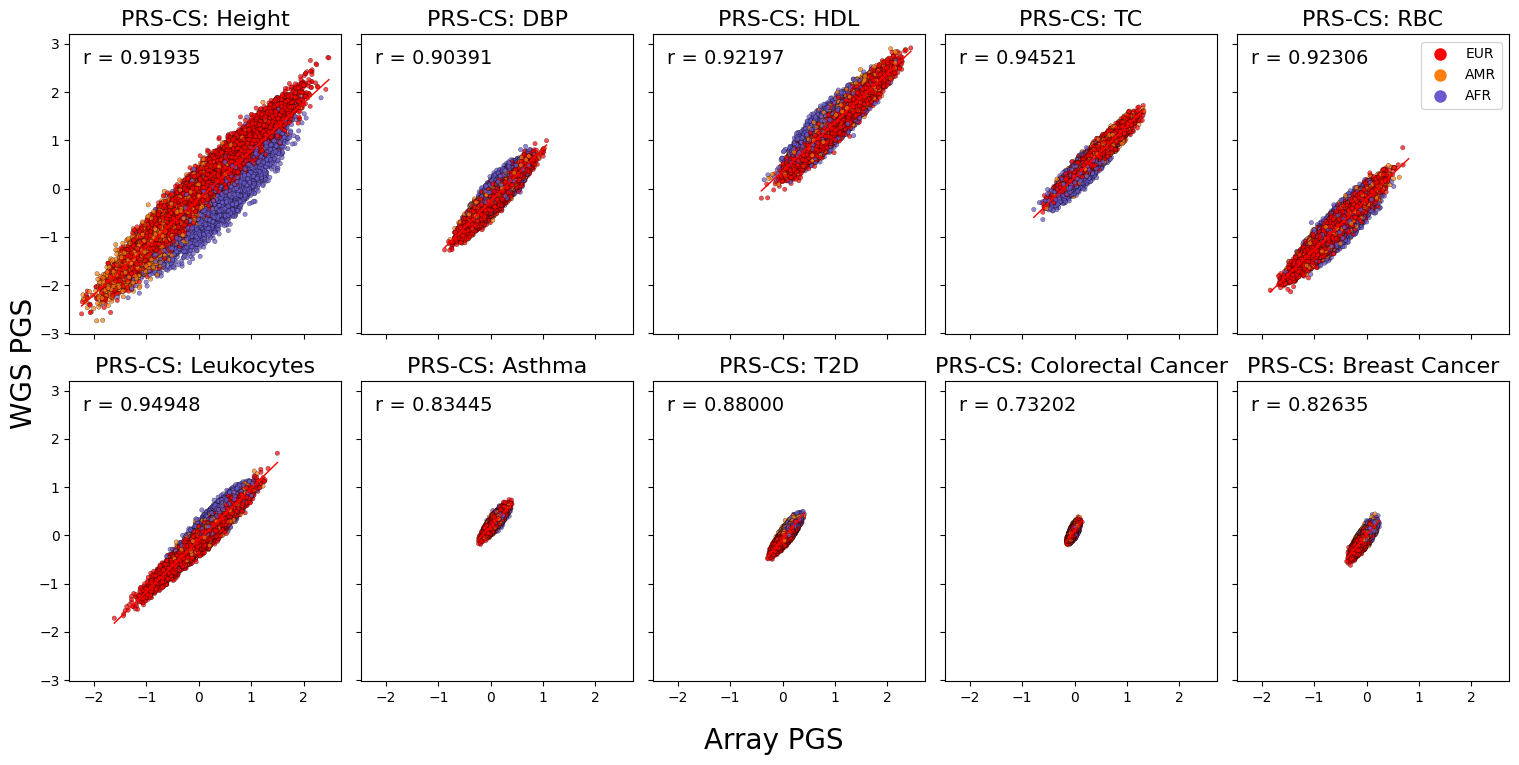

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Original list of phenotypes and DataFrames (assuming dfs is defined as before)
phenotypes = ['Height', 'DBP', 'HDL', 'TC', 'RBC', 'leukocyte', 'Asthma', 'T2D', 'Colorectal_Cancer', 'Breast_Cancer']
dfs = {
    'Height': df_Height,
    'DBP': df_DBP,
    'HDL': df_HDL,
    'TC': df_TC,
    'RBC': df_RBC,
    'leukocyte': df_leukocyte,
    'Asthma': df_Asthma,
    'T2D': df_T2D,
    'Colorectal_Cancer': df_Colorectal_Cancer,
    'Breast_Cancer': df_Breast_Cancer
}

# Rename the phenotypes (3 chosen phenotypes)
phenotypes_renamed = ['Height', 'DBP', 'HDL', 'TC', 'RBC', 'Leukocytes', 'Asthma', 'T2D', 'Colorectal Cancer', 'Breast Cancer']

# Color map for the populations
color_map = {
    'EUR': 'red',
    'AMR': '#ff7f0e',  
    'AFR': 'slateblue'
}

# Create a 2x5 grid of subplots (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(15, 8), sharex=True, sharey=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through the list of phenotypes and plot on each subplot
for i, pheno in enumerate(phenotypes_renamed):
    original_pheno = phenotypes[i]  # Get the original phenotype name to access the dataframe
    if original_pheno in dfs:
        df = dfs[original_pheno]
        
        # Calculate the correlation between the two columns
        correlation = np.corrcoef(df['pgs_x'], df['pgs_y'])[0, 1]

        # Scatter plot of PGS with colors based on Population
        sns.scatterplot(x='pgs_x', y='pgs_y', hue='Population', palette=color_map, data=df, ax=axes[i], 
                        s=10, alpha=0.7, edgecolor='black', legend=False)

        # Regression line (no scatter, just the line)
        sns.regplot(x='pgs_x', y='pgs_y', data=df, ax=axes[i], scatter=False, color='red', line_kws={'linewidth': 1}, ci=None)

        # Labeling the plot
        axes[i].set_xlabel('', fontsize=10)
        axes[i].set_ylabel('', fontsize=10)
        
        # Correct string formatting for the plot title with larger font size
        axes[i].set_title(f'PRS-CS: {pheno}', fontsize=16)

        # Adding the correlation value to the plot with increased font size
        axes[i].text(0.05, 0.95, f'r = {correlation:.5f}', ha='left', va='top', 
                     transform=axes[i].transAxes, color='black', fontsize=14)
    else:
        print(f"DataFrame for {original_pheno} not found.")

    
# Set shared axis titles
fig.supxlabel("Array PGS", fontsize=20)  # Shared x-axis title
fig.text(0, 0.5, "WGS PGS", ha='center', va='center', fontsize=20, rotation=90)  # Shared y-axis title

# Create a custom legend manually (set order and remove title)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[pop], markersize=10) 
           for pop in ['EUR', 'AMR', 'AFR']]

# Add the legend to the upper-right corner inside the plot frame (adjust `bbox_to_anchor`)
fig.legend(handles, ['EUR', 'AMR', 'AFR'], loc='upper right', bbox_to_anchor=(0.99, 0.91), title=None)

# Adjust layout to prevent overlapping subplots and ensure the shared titles fit
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the shared titles

# Show the plot
plt.show()